In [1]:
elastic_rods_dir = '../../../../../elastic_rods/python/'
weaving_dir = '../../../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, get_max_distance_to_target_surface, contact_optimization, get_fixed_boundary_joint)

import vis.fields
import matplotlib.cm as cm
import time

In [2]:
import parallelism
parallelism.set_max_num_tbb_threads(12)
parallelism.set_hessian_assembly_num_threads(4)
parallelism.set_gradient_assembly_num_threads(4)

In [3]:
rod_length = 0.10669341251405501
width = rod_length / 20 * 5
thickness = width / 5 * 0.35
print(width, thickness)
io = InputOrganizer('small_pseudo_sphere_1', thickness, width, weaving_dir)

0.026673353128513752 0.0018671347189959625


In [4]:
OPTS = elastic_rods.NewtonOptimizerOptions()
OPTS.gradTol = 1e-6
OPTS.verbose = 1;
OPTS.beta = 1e-8
OPTS.niter = 200
OPTS.verboseNonPosDef = False
rw = 1
sw = 10

In [5]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, use_constant_width=True)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='white', intensity=0.6, position=(0.0, 0.0, 5.0),…

In [6]:
iterateData = stage_1_optimization(curved_linkage, rw, sw, curved_linkage_view)

In [7]:
def eqm_callback(prob, i):
    curved_linkage_view.update()

In [8]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)

0	1.83992e-05	0.000768733	0.000768733	1	0
1	1.13569e-05	0.00197375	0.00197375	0.5	1
2	1.1145e-05	0.00183688	0.00183688	1	1
3	1.06341e-05	0.000114193	0.000114193	1	0
4	1.05525e-05	0.000661059	0.000661059	1	0
5	1.05348e-05	4.84877e-06	4.84877e-06	1	0
6	1.05346e-05	4.42541e-06	4.42541e-06	1	0
7	1.05346e-05	1.24268e-09	1.24268e-09	1	0


In [9]:
optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, rw, sw)

In [10]:
optimizer, opt_iterateData = stage_2_optimization(optimizer, curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, -1, -5, 3)

rl_regularization_weight 1.0
smoothing_weight 10.0
stage 2 optimization with attraction weight 100.0
stage 2 optimization with attraction weight 0.03162277660168379
stage 2 optimization with attraction weight 1e-05


In [11]:
curved_optimizer_energy = curved_linkage.energy()
validation_curved_linkage = optimizer.getLinesearchWeaverLinkage()
validation_curved_linkage.attraction_weight = 1e-7
with so(): elastic_rods.compute_equilibrium(validation_curved_linkage, options = OPTS, fixedVars = [])
validation_curved_view = linkage_vis.LinkageViewer(validation_curved_linkage, width=1024, height=640)
validation_curved_energy = validation_curved_linkage.energy()
print(abs((validation_curved_energy-curved_optimizer_energy)/curved_optimizer_energy))

2.5098132371448123e-06


In [12]:
validation_curved_view = linkage_vis.LinkageViewerWithSurface(validation_curved_linkage, io.SURFACE_PATH, width=1024, height=640)
set_surface_view_options(validation_curved_view)
validation_curved_view.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='white', intensity=0.6, position=(0.0…

In [13]:
deviation, deviation_vector, joint_normals, joint_projection_normals = get_normal_deviation(validation_curved_linkage)

In [14]:
set_joint_vector_field(validation_curved_linkage, validation_curved_view, deviation_vector)

Min Width  0.026673353128513752
Scale:  187.45299760062832
num seg per rod 15
num seg per rod 15
num seg per rod 22
num seg per rod 15
num seg per rod 15
num seg per rod 22
num seg per rod 22
num seg per rod 22
num seg per rod 15
num seg per rod 15
num seg per rod 15
num seg per rod 15
num seg per rod 15
num seg per rod 15
num seg per rod 15
num seg per rod 15
num seg per rod 22
num seg per rod 15
num seg per rod 22
num seg per rod 22
num seg per rod 15
num seg per rod 15
num seg per rod 22
num seg per rod 15
num seg per rod 15
num seg per rod 15
num seg per rod 15
num seg per rod 15
num seg per rod 15
num seg per rod 15
37.49059952012566


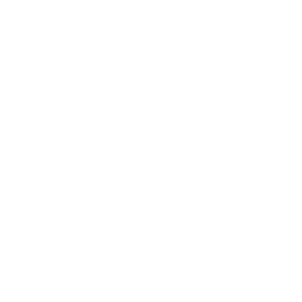

In [15]:
save_path = os.getcwd()
write_all_output(validation_curved_linkage, io.SUBDIVISION_RESOLUTION, io.MODEL_NAME, io.RIBBON_NAME, True, 100, min(io.RIBBON_CS), target_width = 5, flip_angles = True, width = max(io.RIBBON_CS))
os.chdir(save_path)

## Contact Optimization

In [ ]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, use_constant_width=True, interleaving_type=InterleavingType.weaving)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

In [ ]:
curved_linkage.setExtendedDoFsPSRL(np.load('results/small_pseudo_sphere_1/small_pseudo_sphere_1_dof.npy'))

In [ ]:
curved_linkage.attraction_weight = 1e-5

In [ ]:
def eqm_callback(prob, i):
    curved_linkage_view.update()

In [ ]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS, fixedVars = [])

In [ ]:
optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, fixed_boundary_joint = [])

In [ ]:
optimizer.setLinkageAttractionWeight(1e-5)

../../../../../elastic_rods/python/structural_analysis.py:209: RuntimeWarning: invalid value encountered in true_divide
  coefficientOfFriction = cfm[:, 1] / (-separationForce)
/Users/yren/Library/Python/3.7/lib/python/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/yren/Library/Python/3.7/lib/python/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


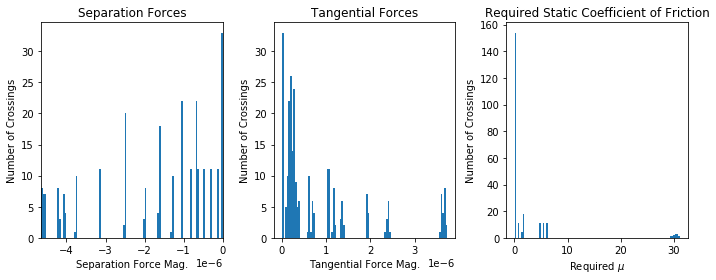

In [16]:
structure_view = get_structure_analysis_view(curved_linkage)
structure_view.show()

In [ ]:
contact_optimization(optimizer, curved_linkage_view, -1, 1e4)

In [ ]:
structure_view_2 = get_structure_analysis_view(curved_linkage)
structure_view_2.show()